# Visualizing Replicate Correlation of Site-Level Profiles

A major question in the decision to split out profiles to site-level instead of well-level, is to determine if there are any extreme biases introduced.

Visualize site-level profile replicate correlation in FIVE categories:

1. Replicate Correlation in **Same Well**
2. Replicate Correlation in **Different Well** in **Same Site** position
3. Replicate Correlation in **Different Well** in **Different Site** position
4. Non-replicate Correlation in **Different Well** in **Same Site** position
5. Non-replicate Correlation in **Different Well** in **Different Site** position 

If we see differences in the same/different site comparisons, then it is likely that the site is providing significant technical biases.

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import plotnine as gg

from pycytominer import audit

from scripts.viz_utils import save_figure

In [2]:
%matplotlib inline

In [3]:
def audit_site(df, audit_cols, batch, plate, resolution="full"):
    
    audit_title = "{}: {}".format(batch, plate)

    site_df = audit(
        df,
        audit_groups=audit_cols,
        audit_resolution=resolution
    )
    
    same_well = site_df.Metadata_Well_pair_a == site_df.Metadata_Well_pair_b
    same_site = site_df.Metadata_Site_pair_a == site_df.Metadata_Site_pair_b
    same_plate = site_df.Metadata_Plate_pair_a == site_df.Metadata_Plate_pair_b
    
    if "Metadata_clone_number" in audit_cols:
        same_treatment = site_df.Metadata_treatment_pair_a == site_df.Metadata_treatment_pair_b
        same_clone = site_df.Metadata_clone_number_pair_a == site_df.Metadata_clone_number_pair_b
    else:
        same_treatment = site_df.Metadata_Dosage_pair_a == site_df.Metadata_Dosage_pair_b
        same_clone = site_df.Metadata_CellLine_pair_a == site_df.Metadata_CellLine_pair_b
    
    replicate = same_treatment & same_clone
    same_well_diff_site = (
        same_well & ~same_site
    )

    same_treatment_diff_well = (
        replicate & ~same_well
    )

    diff_treatment_diff_well = (
        ~replicate & ~same_well
    )

    diff_treatment_diff_site = (
        ~replicate & ~same_site
    )
    
    plot_ready_df = site_df.assign(
        replicate=replicate,
        same_site=same_site,
        same_well_diff_site=same_well_diff_site,
        same_treatment_diff_well=same_treatment_diff_well,
        diff_treatment_diff_well=diff_treatment_diff_well,
        diff_treatment_diff_site=diff_treatment_diff_site
    )
    
    plot_ready_df.pairwise_correlation = plot_ready_df.pairwise_correlation.astype(float)

    plot_ready_df.same_well_diff_site = (
        plot_ready_df
        .same_well_diff_site
        .replace(
            {
                True: "Same Well",
                False: "Different Well"
            }
        )
    )
    
    plot_ready_df.same_site = (
        plot_ready_df
        .same_site
        .replace(
            {
                True: "Same Site",
                False: "Different Site"
            }
        )
    )
    
    site_audit_gg = (
        gg.ggplot(plot_ready_df, gg.aes(x="pairwise_correlation")) + \
            gg.geom_density(gg.aes(fill="replicate"), alpha=0.5) +
            gg.theme_bw() + \
            gg.facet_grid("same_well_diff_site~same_site") +
            gg.ggtitle(audit_title) +
            gg.xlab("Pairwise Pearson Correlation") +
            gg.ylab("Density") +
            gg.theme(
                strip_background=gg.element_rect(colour="black", fill="#fdfff4")
            )
    )
    
    return site_audit_gg

In [4]:
profile_dir = os.path.join("..", "0.generate-profiles", "profiles")
config = "audit_config.yaml"

In [5]:
site_batches = [
    "2019_02_15_Batch1_20X",
    "2019_03_20_Batch2",
    "2019_11_19_Batch5",
    "2019_11_20_Batch6",
    "2019_11_22_Batch7"
]

In [6]:
audit_config = {}
stream = open(config, "r")
for data in yaml.load_all(stream, Loader=yaml.FullLoader):
    batch = data["batch"]
    audit_level = data["auditlevel"]
    plates = [str(x) for x in data["plates"]]
    audit_config[batch] = {}
    audit_config[batch]["plates"] = plates
    audit_config[batch]["auditcols"] = data["auditcols"]
    audit_config[batch]["plate_files"] = {
        x: os.path.join(profile_dir, batch, x, "{}_{}.csv.gz".format(x, audit_level))
        for x in plates
    }

In [7]:
general_audit_cols = ["Metadata_Well", "Metadata_Site", "Metadata_Plate"]

Now auditing... Batch: 2019_02_15_Batch1_20X; Plate: HCT116bortezomib


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


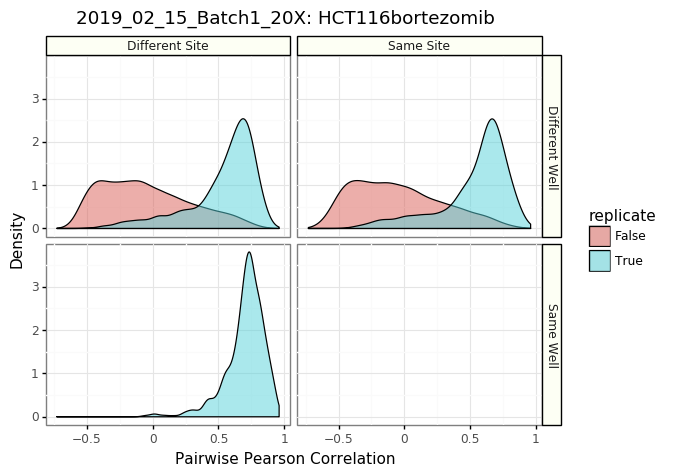

<ggplot: (-9223372036550944084)>


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned.

Now auditing... Batch: 2019_03_20_Batch2; Plate: 207106_exposure320


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


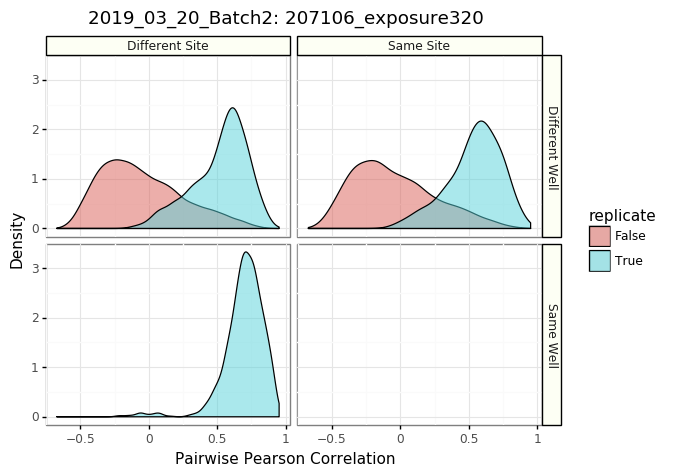

<ggplot: (305667255)>


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned.

Now auditing... Batch: 2019_11_19_Batch5; Plate: 217755


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


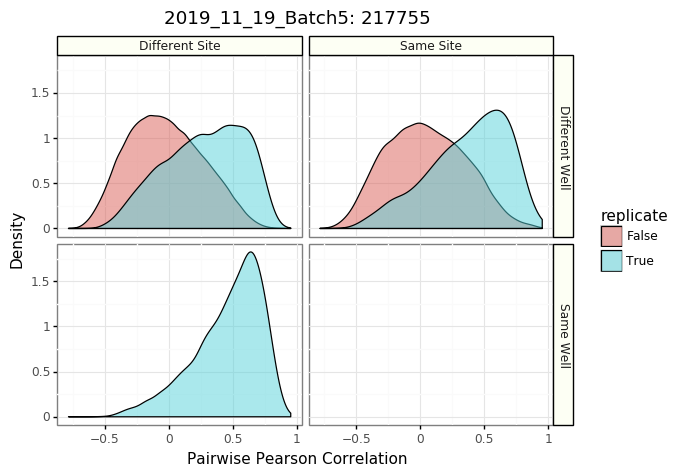

<ggplot: (-9223372036545303145)>


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned.

Now auditing... Batch: 2019_11_20_Batch6; Plate: 217760


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


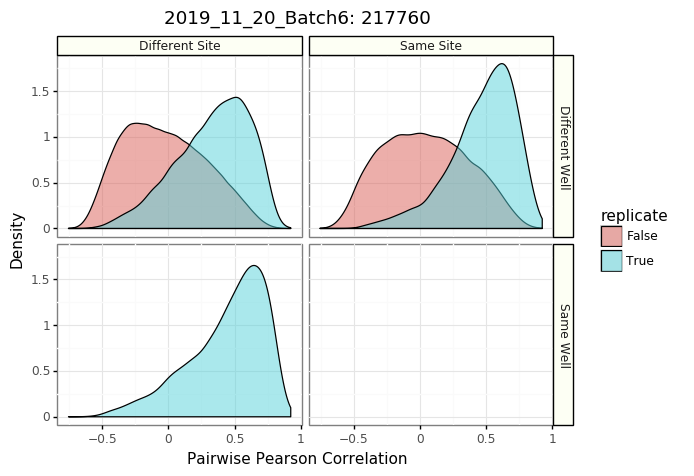

<ggplot: (-9223372036548670334)>


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned.

Now auditing... Batch: 2019_11_20_Batch6; Plate: 217762


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


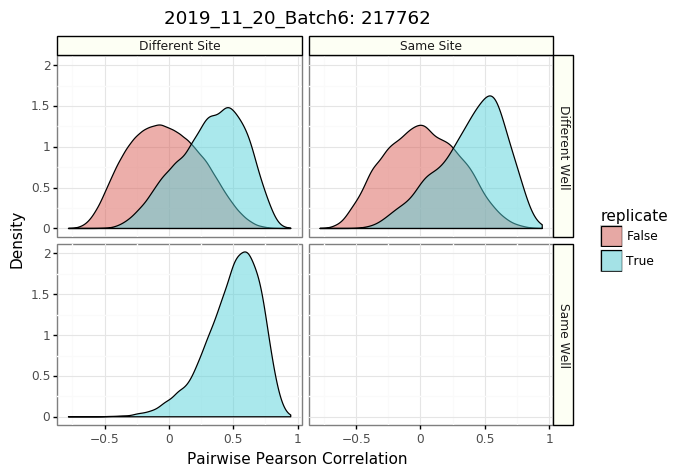

<ggplot: (305204656)>


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned.

Now auditing... Batch: 2019_11_22_Batch7; Plate: 217766


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


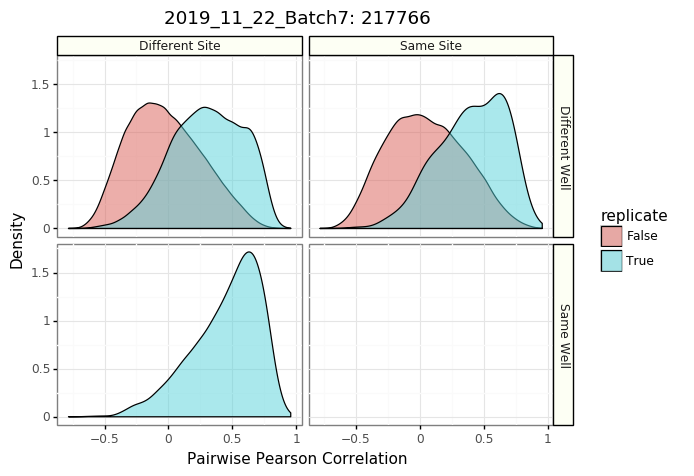

<ggplot: (304680126)>


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned.

Now auditing... Batch: 2019_11_22_Batch7; Plate: 217768


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)


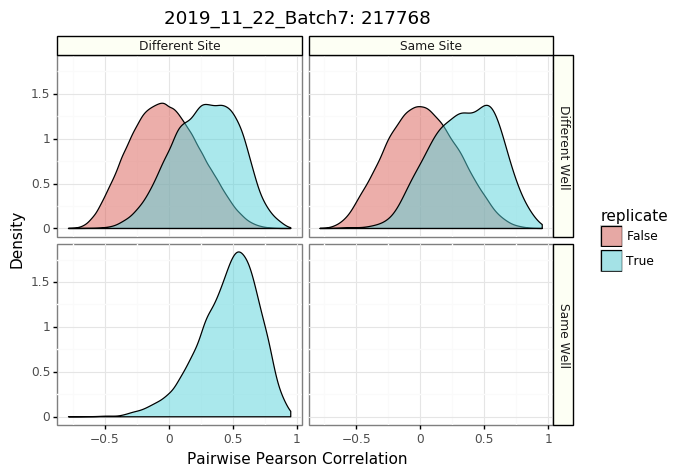

<ggplot: (-9223372036545936917)>


/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat(lst, axis=axis, ignore_index=True)
/Users/gway/miniconda3/envs/resistance-mechanisms/lib/python3.7/site-packages/plotnine/utils.py:629: FutureWarning: Sorting because non-concatenation axis is not aligned.

In [8]:
for batch in audit_config:
    if batch in site_batches:
        batch_dict = audit_config[batch]
        audit_cols = batch_dict["auditcols"]
        site_audit_cols = audit_cols + general_audit_cols
        plate_files = batch_dict["plate_files"]
        plates = batch_dict["plates"]
        for plate in plates:
            figure_dir = os.path.join("figures", batch, plate)
            output_file = os.path.join(
                figure_dir, "{}_{}_site_correlation".format(batch, plate)
            )
            print("Now auditing... Batch: {}; Plate: {}".format(batch, plate))
            df = pd.read_csv(plate_files[plate])
            audit_gg = audit_site(df, site_audit_cols, batch, plate)
            
            print(audit_gg)
            
            save_figure(
                audit_gg,
                output_file,
                dpi=600,
                height=3,
                width=4,
            )